## Preparing images for a new pipeline/framework image for JOSS manuscript

In [8]:
import os
import struct
import pandas as pd
import numpy as np

data_dir = '/projects01/didsr-aiml/jayse.weaver/insilicoich/JOSS_examples/'

df = pd.read_csv(data_dir + 'three_cases.csv')

type_order = ['IPH', 'SDH', 'EDH']
cases_w_me = ['case_000', 'case_002', 'case_004']
cases_wo_me = ['case_001', 'case_003', 'case_005']

HU_slices = [143, 125, 130] # slices with hemorrhage in HU phantoms

# from XCIST:
def rawread(fname, dataShape, dataType):
    # dataType is for numpy, ONLY allows: 'float'/'single', 'double', 'int'/'int32', 'uint'/'uint32', 'int8', 'int16' 
    #          they are single, double, int32, uin32, int8, int16
    with open(fname, 'rb') as fin:
        data = fin.read()
    
    # https://docs.python.org/3/library/struct.html
    switcher = {'float': ['f', 4, np.single], 
                'single': ['f', 4, np.single], 
                'double': ['d', 8, np.double], 
                'int': ['i', 4, np.int32], 
                'uint': ['I', 4, np.uint32],  
                'int32': ['i', 4, np.int32], 
                'uint32': ['I', 4, np.uint32], 
                'int8': ['b', 1, np.int8], 
                'int16': ['h', 2, np.int16]}
    fmt = switcher[dataType]
    data = struct.unpack("%d%s" % (len(data)/fmt[1], fmt[0]), data)
    
    data = np.array(data, dtype=fmt[2])
    if dataShape:
        data = data.reshape(dataShape)
    return data

(480, 480, 350)
(480, 480, 350)
(480, 480, 350)
(480, 480, 350)
(480, 480, 350)
(480, 480, 350)


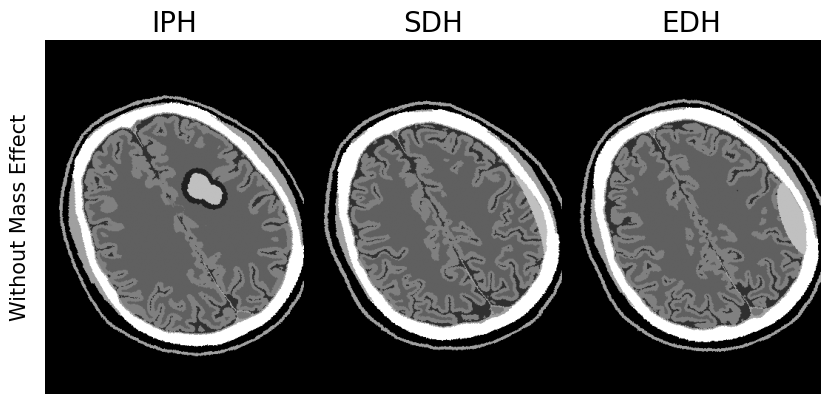

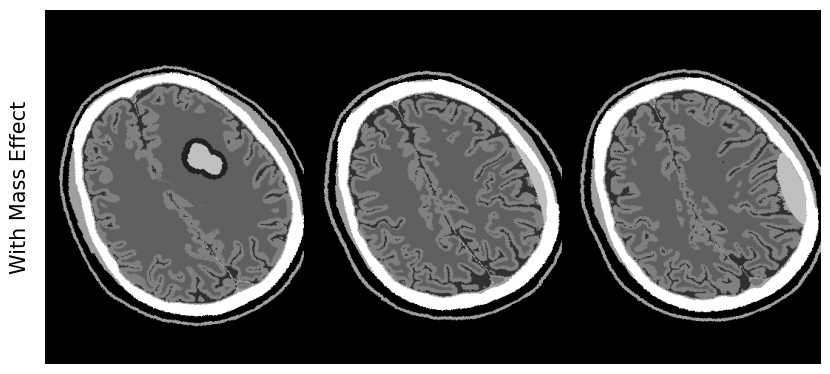

In [ ]:
# load raw HU images without and with mass effect
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=(10,5),gridspec_kw=dict(wspace=0, hspace=0))
for idx, case in enumerate(cases_wo_me):
    fname = data_dir + str(case) + '/phantoms/0/0_HU_data_350x480x480.raw'
    data = rawread(fname, dataShape=[480,480,350], dataType='float')

    axs[idx].imshow(data[HU_slices[idx], :, :], vmin=0, vmax=80, cmap='gray')
    axs[idx].set_title(type_order[idx], size=15)
    if idx == 0:
        axs[idx].set_ylabel('Without Mass Effect', size=15)

    # Hide spines
    axs[idx].spines['top'].set_visible(False)
    axs[idx].spines['right'].set_visible(False)
    axs[idx].spines['bottom'].set_visible(False)
    axs[idx].spines['left'].set_visible(False)
    # Hide ticks
    axs[idx].xaxis.set_ticks_position('none')
    axs[idx].yaxis.set_ticks_position('none')
    # Hide tick labels for x-axis
    axs[idx].set_xticklabels([])
    axs[idx].set_yticklabels([])


fig, axs = plt.subplots(1,3,figsize=(10,5),gridspec_kw=dict(wspace=0, hspace=0))
for idx, case in enumerate(cases_w_me):
    fname = data_dir + str(case) + '/phantoms/0/0_HU_data_350x480x480.raw'
    data = rawread(fname, dataShape=[480,480,350], dataType='float')

    axs[idx].imshow(data[HU_slices[idx], :, :], vmin=0, vmax=80, cmap='gray')
    #axs[idx].set_title(type_order[idx], size=20)
    if idx == 0:
        axs[idx].set_ylabel('With Mass Effect', size=15)

    # Hide spines
    axs[idx].spines['top'].set_visible(False)
    axs[idx].spines['right'].set_visible(False)
    axs[idx].spines['bottom'].set_visible(False)
    axs[idx].spines['left'].set_visible(False)
    # Hide ticks
    axs[idx].xaxis.set_ticks_position('none')
    axs[idx].yaxis.set_ticks_position('none')
    # Hide tick labels for x-axis
    axs[idx].set_xticklabels([])
    axs[idx].set_yticklabels([])


    


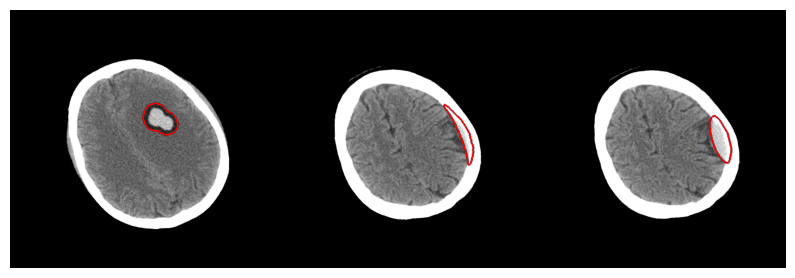

In [14]:
# load XCIST CT output

from image_utils import *
from pathlib import Path
import pandas as pd
import numpy as np
import skimage as ski

from insilicoICH.image_acquisition import read_dicom
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

mask_method = 'boundary' # 'boundary' or 'fill'

study_name = 'JOSS_examples'
#base_dir = Path('../datasets') / study_name
base_dir = Path('/projects01/didsr-aiml/jayse.weaver/insilicoich/') / study_name

metadata = pd.concat([pd.read_csv(o) for o in base_dir.rglob('metadata*.csv')], ignore_index=True).sort_values(by=['name', 'image file']).reset_index(drop=True)
metadata.loc[~metadata.intensity.isna(), 'lesion type'] = metadata[~metadata.intensity.isna()]['lesion type']#.apply(lambda x: x.split("['")[-1].split("']")[0])
metadata.loc[~metadata.intensity.isna(), 'intensity'] = metadata[~metadata.intensity.isna()]['intensity']#.apply(lambda x: float(x.split('[')[-1].split(']')[0])).astype(int)
metadata['image file']=metadata['image file'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata.loc[~metadata['mask file'].isna(), 'mask file']=metadata.loc[~metadata['mask file'].isna(), 'mask file'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata

for n in metadata['name'].unique():
    metadata.loc[metadata['name'] == n, 'slice'] = list(range(len( metadata[metadata['name'] == n])))
metadata['slice'] = metadata['slice'].astype(int)

metadata[~metadata.name.duplicated()]

#from utils import ctshow
window = 'brain'

# NEW FIGURE (focus on correctly identified cases)
cases = ['case_000', 'case_002', 'case_004']

slice_averaging = True # True -> 5mm , False -> 1mm

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), gridspec_kw=dict(wspace=0, hspace=0))
for idx, ax in enumerate(axs.flat):
    case = cases[idx]
    z = metadata[(metadata['name'] == case) & (metadata['lesion volume [mL]']>0)]['center z'].iloc[0].astype(int)
    
    if not slice_averaging:
        mask = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['mask file'].item())
        img = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['image file'].item())
    else:
        img = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z-2)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z-1)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z+1)]['image file'].item())
        img = img + read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z+2)]['image file'].item())
        img = img/5

        mask = read_dicom(metadata[(metadata['name'] == case) & (metadata['slice']==z)]['mask file'].item())

    if mask_method == 'boundary':
        labels, num = ski.measure.label(mask, background=0, connectivity=1, return_num=True)
        assert( labels.max() != 0 )
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        mask = ski.segmentation.find_boundaries(largestCC.astype('bool'), mode='thick', background=0)
        mask = ski.segmentation.find_boundaries(mask.astype('bool'), mode='thick', background=0)
        alpha = 1.0
        cmap='bwr_r'
    else:
        # mask_method == 'fill'
        alpha = 0.5
        cmap='Reds_r'

    age =  metadata[metadata['name'] == case].iloc[z]['age'].astype(int)
    
    lesion_type = metadata[metadata['name'] == case].iloc[z]['lesion type']
    vol =  metadata[metadata['name'] == case]['lesion volume [mL]'].sum()
    intensity = metadata[metadata['name'] == case].iloc[z]['intensity']
    
    new_mask = np.ma.masked_where(mask == 0, mask)
    ax.imshow(img, cmap='gray', vmin=0, vmax=80)
    ax.imshow(new_mask, cmap=cmap, alpha=alpha)

    ax.axis("off")